# Merchant Recommendation - aggiunta di info covariate

In [1]:
!pip install pyathena
!pip install kneed

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from esbmr2 import esbmr2
from hpf_vi import hpf_vi
from pyathena import connect
import boto3
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import datetime
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from importlib import reload
from esbmr2 import esbmr2

# %% Importing custom modules
import train_test_split
import data_processing
import scoring
from CF import CF # importing the class for the heuristics

In [3]:
import pandas as pd
import numpy as np
import time
from functools import partial
import multiprocessing
from importlib import reload
# Custom modules
import multiprocessing_functions
reload(multiprocessing_functions)
from CF import CF

In [4]:
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
STAGING_BUCKET = 'nexi-tmp-athena-staging'
STAGING_AREA = 'tmp-athena-queries'
REGION_NAME = 'eu-west-1'
cursor = connect(s3_staging_dir="s3://{}/{}".format(STAGING_BUCKET,STAGING_AREA),
                 region_name=REGION_NAME,
                 work_group='WKGP-SM-DATA'
                ).cursor()
def runQueryFromString(sqlQuery):
    cursor.execute(sqlQuery)
    resultPath = cursor.output_location.replace('s3://','').split('/')
    try:
        obj = s3_client.get_object(Bucket=resultPath[0], Key=resultPath[1] + '/' + resultPath[2])
    except:
        return None
    return pd.read_csv(obj['Body'])

## Import dei dati
1. Interazioni carte-merchant con conteggio
2. Covariate carte
3. Covariate merchant

In [5]:
df =  runQueryFromString("""
SELECT * FROM merch_recom.interazioni_sbt_2020_attivi
""")

In [6]:
df.head()

,id_car,post_code_mov,id_cluster,nm_nome_cleaned,conteggio,co_corr_acq,co_ese_acc,nm_nome_acc,id_macro_prod_iss,te_macro_prod_iss,id_fam_prod_iss,te_fam_prod_iss,id_ctg_2,te_ctg_2,id_macro_ctg_2,te_macro_ctg_2,co_proc_pv,co_pv
0,F33EB32072FBED8B465A64FEC1DB977E,63074.0,241,PARAFARMACIA SAN BENEDET,1,434495,394756500117001,PARAFARMACIA SAN BENEDET,1,Classic,1,Classic e Rateali,34,PRODOTTI SANITARI,7,RETAIL,NaN,NaN
1,89855A2B8963D0106079FCB552323462,63074.0,241,PARAFARMACIA SAN BENEDET,1,434495,394756500117001,PARAFARMACIA SAN BENEDET,1,Classic,1,Classic e Rateali,34,PRODOTTI SANITARI,7,RETAIL,NaN,NaN
2,753C4AA227C63F070EAFB3D8BEEED475,63074.0,241,PARAFARMACIA SAN BENEDET,1,434495,394756500117001,PARAFARMACIA SAN BENEDET,1,Classic,1,Classic e Rateali,34,PRODOTTI SANITARI,7,RETAIL,NaN,NaN
3,3CAC2708C269ABEB6E5783FB354B99A7,63074.0,241,PARAFARMACIA SAN BENEDET,5,434495,394756500117001,PARAFARMACIA SAN BENEDET,1,Classic,1,Classic e Rateali,34,PRODOTTI SANITARI,7,RETAIL,NaN,NaN
4,79A2E3540CD3180A789F7F17E458EDC8,63074.0,241,PARAFARMACIA SAN BENEDET,1,434495,394756500117001,PARAFARMACIA SAN BENEDET,1,Classic,1,Classic e Rateali,34,PRODOTTI SANITARI,7,RETAIL,NaN,NaN


In [7]:
df = df.sort_values("id_car")

In [243]:
df[df['conteggio']>=10] = 10

In [8]:
covar_merchant = runQueryFromString("""
SELECT * FROM merch_recom.covar_merchant
""")
covar_carte = runQueryFromString("""
SELECT * FROM merch_recom.covar_carte
""")

In [9]:
covar_merchant = covar_merchant.sort_values("nm_nome_cleaned")
covar_merchant.head()

,nm_nome_cleaned,te_ctg_2,avg_spe,tot_spe,nu_trx
34,AGRIFARMA,ARTICOLI SPORTIVI,49.048300,173729.08,3542
21,ANGOLO,PROFUMERIE,173.142857,12120.00,70
7,ARCAPLANET,ANIMALI E ACCESSORI,43.180019,380675.05,8816
87,ART ET PARFUM,PROFUMERIE,334.255556,120332.00,360
8,BALDASSARRI OTTICA,CINE FOTO OTTICA,173.891544,94597.00,544


In [10]:
covar_carte = covar_carte.sort_values("id_car")
covar_carte.head()

,id_car,n_transaz_2020,va_lim_uti,dt_nasc,dt_prima_sped
216,0017585EF174473DBA79173E5329F793,172,5200.0,1975-12-01 00:00:00.000,2016-12-29 00:00:00.000
67,0042FE3E0748C5197B868D71BF2A3FE6,290,1600.0,1976-10-01 00:00:00.000,2016-09-09 00:00:00.000
277,00A49D6841C8DD0970B171B357CCBCDC,135,1600.0,1962-12-01 00:00:00.000,2002-08-10 00:00:00.000
126,02526C5C76CBAA759E42EC003038A308,235,1600.0,1973-12-01 00:00:00.000,2002-03-08 00:00:00.000
204,02D680C742FC8B7C32BA883CCF0EFC04,179,5000.0,1977-07-01 00:00:00.000,2017-10-10 00:00:00.000


### Feature Engineering

In [11]:
covar_carte["dt_nasc"] = covar_carte["dt_nasc"].str.slice(0,4)
covar_carte["dt_prima_sped"] = covar_carte["dt_prima_sped"].str.slice(0,4)

covar_carte['n_transaz_2020_bin'] = pd.cut(x=covar_carte['n_transaz_2020'], bins=[0, 50, 100, 200, 1000])
covar_carte["n_transaz_2020_bin"] = pd.Categorical(covar_carte.n_transaz_2020_bin).codes

covar_carte['dt_nasc_bin'] = pd.cut(x=covar_carte['dt_nasc'].astype(int), bins=[1900, 1940, 1960, 1980, 1990])
covar_carte["dt_nasc_bin"] = pd.Categorical(covar_carte.dt_nasc_bin).codes

covar_carte['dt_prima_sped_bin'] = pd.cut(x=covar_carte['dt_prima_sped'].astype(int), bins=[covar_carte['dt_prima_sped'].astype(int).min(), 2005, 2010, 2015, covar_carte['dt_prima_sped'].astype(int).max()])
covar_carte["dt_prima_sped_bin"] = pd.Categorical(covar_carte.dt_prima_sped_bin).codes

covar_carte['va_lim_uti_bin'] = pd.cut(x=covar_carte['va_lim_uti'].astype(int), bins=[covar_carte['va_lim_uti'].astype(int).min(), 2500, 5000, covar_carte['va_lim_uti'].astype(int).max()])
covar_carte["va_lim_uti_bin"] = pd.Categorical(covar_carte.va_lim_uti_bin).codes

In [13]:
covar_carte.head()

,id_car,n_transaz_2020,va_lim_uti,dt_nasc,dt_prima_sped,n_transaz_2020_bin,dt_nasc_bin,dt_prima_sped_bin,va_lim_uti_bin
216,0017585EF174473DBA79173E5329F793,172,5200.0,1975,2016,2,2,3,2
67,0042FE3E0748C5197B868D71BF2A3FE6,290,1600.0,1976,2016,3,2,3,0
277,00A49D6841C8DD0970B171B357CCBCDC,135,1600.0,1962,2002,2,2,0,0
126,02526C5C76CBAA759E42EC003038A308,235,1600.0,1973,2002,3,2,0,0
204,02D680C742FC8B7C32BA883CCF0EFC04,179,5000.0,1977,2017,2,2,3,1


In [91]:
# covar_c = np.array(covar_carte.sort_values('id_car')['n_transaz_2020_bin']) # np.array:n_transaz_2020 and va_lim_uti
covar_c = np.array(covar_carte.sort_values('id_car')[['n_transaz_2020', 'dt_nasc']]) # np.array:n_transaz_2020 and va_lim_uti
# covar_c = np.array(covar_carte.sort_values('id_car')['n_transaz_2020_bin']) # np.array:n_transaz_2020 and va_lim_uti

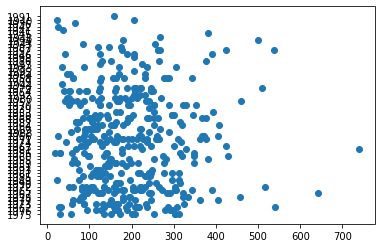

In [92]:
plt.scatter(x=covar_carte["n_transaz_2020"], y=covar_carte["dt_nasc"])

In [93]:
covar_c = covar_c.astype(float)

In [94]:
covar_merchant['co_ctg_2'] = pd.Categorical(covar_merchant.te_ctg_2).codes
covar_m = np.array(covar_merchant.sort_values('nm_nome_cleaned')[['co_ctg_2', 'avg_spe','tot_spe','nu_trx']])
covar_m.dtype

dtype('float64')

In [95]:
covar_merchant

,nm_nome_cleaned,te_ctg_2,avg_spe,tot_spe,nu_trx,co_ctg_2
34,AGRIFARMA,ARTICOLI SPORTIVI,49.048300,173729.08,3542,3
21,ANGOLO,PROFUMERIE,173.142857,12120.00,70,11
7,ARCAPLANET,ANIMALI E ACCESSORI,43.180019,380675.05,8816,1
87,ART ET PARFUM,PROFUMERIE,334.255556,120332.00,360,11
8,BALDASSARRI OTTICA,CINE FOTO OTTICA,173.891544,94597.00,544,5
...,...,...,...,...,...,...
71,TAG S,ARTE E COLLEZIONISMO,150.392857,12633.00,84,2
13,TEOREMA,CARTOLIBRERIE,37.627143,7901.70,210,4
38,TIGOTA,PROFUMERIE,28.744048,424779.54,14778,11
47,URBAN ESSENCE,PROFUMERIE,46.960000,2817.60,60,11


In [96]:
reload(data_processing)
expl, id_car, nm_nome_cleaned = data_processing.cross_tab(df)
train, test = train_test_split.train_val_split(expl)

## Fit del modello - implicit feedback
Il modello è fittato con l'aggiunta di covariate.

In [245]:
del model
impl = expl.copy()
impl[expl.nonzero()] = 1
train_i, test_i = train_test_split.train_val_split(impl)
model = esbmr2(prior_u = 'GN', prior_i = 'DP', components = 10, gamma = 0.475, beta = 0.1, sigma = 0.4, alpha_urn_u = 2.55, alpha_urn_i = 2.55, a = 0.3, b = 0.5)
model.fit(train[:,:], 100, 
#           xu = covar_c[:,:].T, xu_type = ["count", "count"], 
#           alpha_xu = 1.5, 
#           alpha_xi = 1.5, 
#           xi = covar_m[:,:].T, xi_type = ["categ", "cont", "cont", "count"]
         )
# pred_i = model.predict(test_i)

------------------
Initial log-likelihood: -3.0414093201713376e+64
------------------
Gibbs Sampling simulation starts.
Iteration 0 complete. Log-likelihood: -3.0414093201713376e+64.
Iteration 10 complete. Log-likelihood: -3.0414093201713376e+64.
Iteration 20 complete. Log-likelihood: -3.0414093201713376e+64.
Iteration 30 complete. Log-likelihood: -3.0414093201713376e+64.
Iteration 40 complete. Log-likelihood: -3.0414093201713376e+64.
Iteration 50 complete. Log-likelihood: -3.0414093201713376e+64.
Iteration 60 complete. Log-likelihood: -3.0414093201713376e+64.
Iteration 70 complete. Log-likelihood: -3.0414093201713376e+64.
Iteration 80 complete. Log-likelihood: -3.0414093201713376e+64.
Iteration 90 complete. Log-likelihood: -3.0414093201713376e+64.
Runtime: 76.70952486991882
Computing block interactions...
Block-interactions (mode estimator) computed.
Block-interactions (k-means estimator) computed.
End: 1605909920.5982869


In [246]:
model.co_clustering_matrices()

## Community detection
### 1. Carte
Ciascun cluster è caratterizzato da diversi valori di interazione con i vari cluster dei merchant.

La stima basata su KMeans è leggermente discordante poiché individua meno cluster.

In [220]:
# mod2.KMeans_estimator(method_u = "silhouette", method_i = "silhouette") # computes the KMeans estimator

In [247]:
# model.vi_estimator()
np.unique(model.zu_est)
# model.zu_est_vi
# np.unique(model.zu_est_kmeans)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

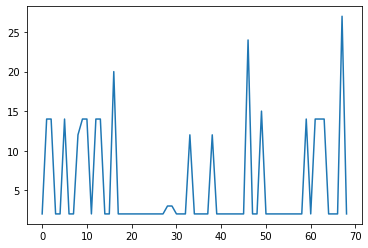

In [248]:
plt.plot(model.zu_mcmc[:,20])

In [249]:
# model.vi_estimator()
np.unique(model.zi_est)
# model.zu_est_vi
# np.unique(model.zi_est_kmeans)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [250]:
pred, pred_kmeans = model.predict(test[:,:])
print(sum([scoring.roc_auc(train_i[:,:],test_i[:,:], pred) for i in range(20)])/20)

0.8200316060427039


In [251]:
scoring.mse(train_i,test_i,pred)

0.5395819089497629

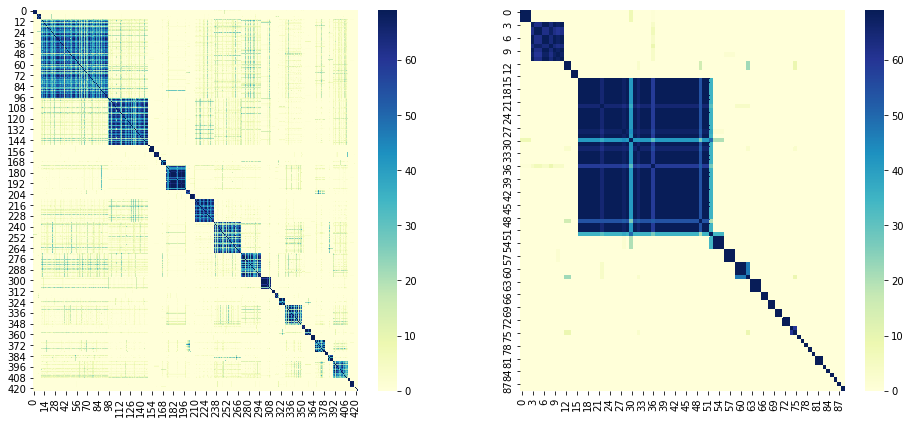

In [255]:
gig, ax = plt.subplots(figsize=(16,7),ncols=2,nrows=1)
sns.heatmap(ax=ax[0],data=model.ccmatrix_u, cmap = 'YlGnBu')
sns.heatmap(ax=ax[1],data=model.ccmatrix_i, cmap = 'YlGnBu')
# plt.savefig("ccmatrix_covar.pdf")

### 2. Merchant
Il modello individua 12 cluster di merchant.

La stima basata su KMeans rileva 3 cluster. (!!!)

Rispetto alle carte, il clustering dei merchant appare più netto.

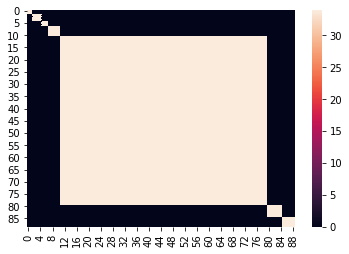

In [35]:
sns.heatmap(model.ccmatrix_i)

### Clustering at a glance

In [240]:
# id_car_clustered = np.vstack((id_car, model.zu_est)).T
merchant_clustered = np.vstack((nm_nome_cleaned[:100], model.zi_est)).T
for i in range(model.zi_est.shape[0]):
    print(merchant_clustered[merchant_clustered[:,1] == i])

[['AGRIFARMA' 0]
 ['BUFFETTI' 0]
 ['FARMACIA ROSINI' 0]
 ['FARMACIE ANGELINI' 0]
 ['FLYING TIGERSBDEL TRON' 0]
 ['GALEAZZI PROFUMERIA' 0]
 ['KIKO' 0]
 ['SOCIETA AGRICOLA TERRA E' 0]]
[['FARMACIA CARLINI' 1]
 ['FARMACIA OLIVIERI' 1]
 ['FARMACIA TOMASSINI' 1]
 ['FARMACIE ANGELINI DI' 1]
 ['TIGOTA' 1]]
[['ART ET PARFUM' 2]
 ['BALDASSARRI OTTICA' 2]
 ['BATUFFOLI COCCOLE' 2]
 ['CARTOLIBRERIA ALIF' 2]
 ['FLYING TIGERSBDEL T' 2]
 ['IL MARENGO' 2]
 ['LA NUOVA ERBORISTERIA DE' 2]
 ['MARE CHEF' 2]
 ['NAVE CERVO' 2]
 ['OTTICA PANSARINI' 2]
 ['OTTICA TALAMONTI' 2]
 ['OTTICA VERDEROSA' 2]
 ['PIUNTI QUINTO' 2]
 ['RCB COLOURS BEAU' 2]
 ['SARNI ORO' 2]
 ['SHINE' 2]
 ['VISOH' 2]]
[['ERBAMICA ERBORISTERIA' 3]
 ['FARMACIA ADRIATICA' 3]
 ['GIOCHERIA' 3]
 ['GIOIELLERIA FENOCCHI' 3]
 ['LIBRERIA MONDADORI ZELIG' 3]
 ['MEDICAL SAN' 3]
 ['PARAFARMACIA SAN BENEDET' 3]
 ['SPIPERCART' 3]]
[['BEAUTIFUL HAIR' 4]
 ['BLOOMING' 4]
 ['CICLOFFICINA' 4]
 ['DOUGLAS ITALIA' 4]
 ['EQUIVALENZA' 4]
 ['GALILEI CENTRO OTTICO' 4

## Matrice di interazione carte-merchant
- L'heatmap riporta il grado di interazione normalizzato tra cluster di user e cluster di item.
- Le prediction si baseranno su tali valori

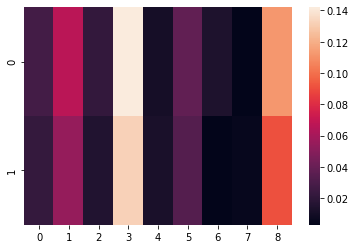

In [205]:
sns.heatmap(model.theta_est)

### Accuracy vs. Novelty
L'accuracy del modello "risente" della struttura a blocchi, che tuttavia si rivela utile per raccomandare novità agli utenti.

$Accuracy = \frac{\text{# correct predictions}}{\text{# total predictions}}$

In [70]:
pred_i = pred_i / pred_i.max()

## Generare raccomandazioni
- La funzione <b>block recommend</b> ritorna i merchant suddivisi per cluster.

In [43]:
# u1, u2 = 0,10
# print(f" - Recommendations for user {u1}: ",model.block_recommend([0],5))
# print(f" - Recommendations for user {u2}: ",model.block_recommend([10],5))

### Affrontare il problema del "cold start"
"Cold start" è l'espressione usata per indicare il problema di raccomandare items a users non inclusi nel dataset iniziale.

Nell'ambito del modello in questione, in cui tutte le quantità sono modellate secondo distribuzioni di probabilità, è sufficiente una ipotesi per produrre "cold-start recommendations", ovvero che lo user abbia probabilità di appartenere ad uno dei cluster di users proporzionalmente alla loro cardinalità. In questo modo, le raccomandazioni saranno medie pesate delle raccomandazioni per gli users con cui è stato allenato il modello.

Nel nostro caso, per una carta $c$ sconosciuta, l'interazione stimata sarà:
$$ \theta_{c,i} = \sum_{h=1}^{H} w_{h} \cdot \theta_{h,c^I} $$
dove $w_h$ è la frequenza relativa di user nel cluster $h$ e $c^I$ è il cluster assignment del merchant $i$.

In [ ]:
# cold start

## Confronto con un'euristica: memory-based collaborative filtering
Un memory-based collaborative filtering è un algoritmo di raccomandazione basato unicamente su logiche algoritmiche. Non vi è dunque alcun fitting di modello. Il CF implementato è un CF user-based: le raccomandazioni per ciascuna carta sono la media aritmetica dei movimenti delle 10 carte più simili. 

In [194]:
cf = CF()
cf.fit(train_i[:,:], 10)

array([[0.1, 0.2, 0.2, ..., 0.4, 0. , 0. ],
       [0.1, 0.2, 0.2, ..., 0.4, 0. , 0. ],
       [0.1, 0.1, 0.2, ..., 0.4, 0. , 0. ],
       ...,
       [0.2, 0.1, 0.2, ..., 0.3, 0. , 0.1],
       [0.1, 0.2, 0.1, ..., 0.3, 0. , 0. ],
       [0.1, 0.2, 0.2, ..., 0.3, 0. , 0. ]])

## Confronto con un modello concorrente: Hierarchical Poisson Factorization (HPF)
HPF è un latent feature model: al contrario dell'ESBMR, individua un vettore di feature per ciascuna carta e per ciascun merchant. Ciò si traduce in una elevata complessità modellistica, che limita le possibilità di fare inferenza dal modello.

Per i nostri dati, HPF genera 35890 parametri. ESBMR appena 104! Nonstante ciò, i due modelli hanno performance comparabili.

In [195]:
hpf = hpf_vi()
hpf.fit(train_i[:,:], 10, valid = test_i[:,:])

/home/ec2-user/SageMaker/dst-merchant-recommendation/hpf_vi.py:189: RuntimeWarning:

divide by zero encountered in log



Iteration 1 completed. Log-likelihood: -4790.511618537938
Iteration 2 completed. Log-likelihood: -3402.52137300973
Iteration 3 completed. Log-likelihood: -3244.0377928792864
Iteration 4 completed. Log-likelihood: -3088.0612946703864
Iteration 5 completed. Log-likelihood: -2957.617931835629
Iteration 6 completed. Log-likelihood: -2864.927288513322
Iteration 7 completed. Log-likelihood: -2799.1148789101703
Iteration 8 completed. Log-likelihood: -2754.295489143631
Iteration 9 completed. Log-likelihood: -2723.4890964834804
Iteration 10 completed. Log-likelihood: -2699.939868035568
Stopped after 2.152 seconds, 10 iterations. Log-likelihood: -2699.939868035568.


## Performance metrics
1. Mean squared Error (MSE): in-sample and out-of-sample
2. Accuracy score
3. Sensitivity
3. Area under the ROC curve (AUC) - <i> for implicit feedback only </i>
4. Precision-at-z
5. Recall-at-z

### 1. Mean Squared Error

In [206]:
reload(scoring)
scoring.mse(train_i, test_i, pred)

0.04843454677340472

### Random predictor

In [207]:
pred_rand = np.random.randn(test.shape[0], test.shape[1])

## AUC: confronto con le baseline

In [209]:
reload(scoring)
print(f"Score for CF: {scoring.roc_auc(train_i, test_i, cf.pred)}")
print(f"Score for ESBMR: {scoring.roc_auc(train_i, test_i, pred)}")
print(f"Score for HPF: {scoring.roc_auc(train_i, test_i, hpf.predicted)}")
print(f"Score for random: {scoring.roc_auc(train_i, test_i, pred_rand)}")

Score for CF: 0.6355510169634568
Score for ESBMR: 0.7483769094438348
Score for HPF: 0.7156696767659718
Score for random: 0.4915906827580387


### Distribuzione dell'AUC al variare del test set per i quattro recommender system
ei grafici, in ordine: CF, ESBMR, HPF, random

(array([1., 1., 2., 4., 4., 3., 9., 6., 4., 4., 8., 4.]),
 array([0.48178665, 0.48278324, 0.48377984, 0.48477644, 0.48577303,
        0.48676963, 0.48776622, 0.48876282, 0.48975942, 0.49075601,
        0.49175261, 0.49274921, 0.4937458 ]),
 <a list of 12 Patch objects>)

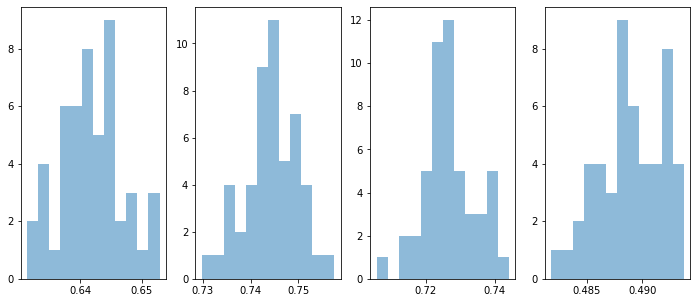

In [181]:
fig, ax = plt.subplots(figsize = (12,5), ncols = 4)

ax[0].hist([scoring.roc_auc(train_i,test_i, cf.pred) for i in range(50)], bins = 12, alpha = 0.5)
ax[1].hist([scoring.roc_auc(train_i,test_i, pred_i) for i in range(50)], bins = 12, alpha = 0.5)
ax[2].hist([scoring.roc_auc(train_i,test_i, hpf.predicted) for i in range(50)], bins = 12, alpha = 0.5)
ax[3].hist([scoring.roc_auc(train_i,test_i, pred_rand) for i in range(50)], bins = 12, alpha = 0.5)

### Mean Squared Error - comparazione

In [211]:
reload(scoring)
print(f"Score for CF: {scoring.mse(train_i, test_i, cf.pred)}")
print(f"Score for ESBMR: {scoring.mse(train_i, test_i, pred)}")
print(f"Score for HPF: {scoring.mse(train_i, test_i, hpf.predicted)}")
print(f"Score for random: {scoring.mse(train_i, test_i, pred_rand)}")

Score for CF: 0.06086444007858547
Score for ESBMR: 0.04889245696214501
Score for HPF: 0.050957889821202605
Score for random: 1.0218982189180306


In [183]:
model.recall_at_z(test_i, pred_i, threshold = 0.1)

0.2069408740359897

Recall-at-z is much higher than precision-at-z: as expected, since the model is based on a block structure, 
it will suggest many items that are in line with the preference of the user, but that the user never consumed.
Hence, on the one hand, we get a relatively low precision-at-z.
On the other hand, a high recall confirms that the model detects a high proportion of relevant items on the total.

In [130]:
!jupyter nbconvert ESBMR_analysis_implicit.ipynb --to html --no-input

[NbConvertApp] Converting notebook ESBMR_analysis_implicit.ipynb to html
[NbConvertApp] Writing 559231 bytes to ESBMR_analysis_implicit.html
